# Classifying Names with a Character-Level RNN

The notebook is based on the [this PyTorch Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#creating-the-network).

In [1]:
%matplotlib inline

In [54]:
import glob
import math
import time
import random
from os.path import expanduser, basename, splitext

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
torch.manual_seed(1)

In [6]:
# !wget https://download.pytorch.org/tutorial/data.zip -O ~/data.zip
# !unzip ~/data.zip -d ~
# !mkdir ~/data/names/names
# !mv ~/data/names/*.txt ~/data/names/names
# !mv ~/data/eng-fra.txt ~/data/names/eng-fra.txt
# !rm ~/data.zip

--2018-08-20 21:45:35--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 205.251.219.72, 205.251.219.66, 205.251.219.114, ...
Connecting to download.pytorch.org (download.pytorch.org)|205.251.219.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘/home/ck/data.zip’

/home/ck/data.zip   100%[===================>]   2.75M  4.72MB/s    in 0.6s    

2018-08-20 21:45:36 (4.72 MB/s) - ‘/home/ck/data.zip’ saved [2882130/2882130]

Archive:  /home/ck/data.zip
  inflating: /home/ck/data/eng-fra.txt  
   creating: /home/ck/data/names/
  inflating: /home/ck/data/names/Arabic.txt  
  inflating: /home/ck/data/names/Chinese.txt  
  inflating: /home/ck/data/names/Czech.txt  
  inflating: /home/ck/data/names/Dutch.txt  
  inflating: /home/ck/data/names/English.txt  
  inflating: /home/ck/data/names/French.txt  
  inflating: /home/ck/data/names/German.txt  
  inflating: /home/ck

In [5]:
PATH = expanduser('~/data/names/names')

In [6]:
!ls $PATH

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [7]:
import unicodedata
import string

In [8]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [9]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

In [10]:
unicode_to_ascii('Ślusàrski')

'Slusarski'

In [11]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [40]:
category_lines = {}
all_categories = []

for filename in glob.glob(PATH + '/*.txt'):
    print(f'reading file {filename}')
    category, _ = splitext(basename(filename))
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

reading file /home/ck/data/names/names/Chinese.txt
reading file /home/ck/data/names/names/English.txt
reading file /home/ck/data/names/names/Korean.txt
reading file /home/ck/data/names/names/Portuguese.txt
reading file /home/ck/data/names/names/German.txt
reading file /home/ck/data/names/names/Dutch.txt
reading file /home/ck/data/names/names/Arabic.txt
reading file /home/ck/data/names/names/Spanish.txt
reading file /home/ck/data/names/names/Scottish.txt
reading file /home/ck/data/names/names/French.txt
reading file /home/ck/data/names/names/Italian.txt
reading file /home/ck/data/names/names/Irish.txt
reading file /home/ck/data/names/names/Russian.txt
reading file /home/ck/data/names/names/Vietnamese.txt
reading file /home/ck/data/names/names/Czech.txt
reading file /home/ck/data/names/names/Greek.txt
reading file /home/ck/data/names/names/Japanese.txt
reading file /home/ck/data/names/names/Polish.txt


In [14]:
def letter_to_index(letter):
    return all_letters.find(letter)

In [15]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [16]:
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for index, letter in enumerate(line):
        tensor[index][0][letter_to_index(letter)] = 1
    return tensor

In [17]:
letter_to_tensor('J')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [18]:
line_to_tensor('Jones').size()

torch.Size([5, 1, 57])

In [19]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, i, h):
        combined = torch.cat((i, h), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [20]:
n_hidden = 128

In [21]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
input_tensor = letter_to_tensor('A')
hidden = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden)
output

tensor([[-2.8739, -2.9028, -2.8908, -2.8810, -2.9101, -2.8985, -2.9106, -2.9278,
         -2.9383, -2.8299, -2.8164, -2.7802, -3.0030, -2.8686, -2.8727, -2.9259,
         -2.9581, -2.8613]], grad_fn=<LogSoftmaxBackward>)

In [28]:
def top_category(output):
    top_value, top_indices = output.topk(1)
    category_index = top_indices[0].item()
    return all_categories[category_index], category_index

In [29]:
top_category(output)

('Irish', 11)

In [57]:
def random_training_example():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = line_to_tensor(line)
    return (category, line), (category_tensor, line_tensor)

In [58]:
for i in range(10):
    category_and_line, _ = random_training_example()
    print('category = %-10s / line = %-20s' % category_and_line)

category = English    / line = Mccall              
category = Russian    / line = Anufrienko          
category = Arabic     / line = Hajjar              
category = Spanish    / line = Etxebarria          
category = Russian    / line = Zhitin              
category = Russian    / line = Chijik              
category = Spanish    / line = Flores              
category = Dutch      / line = Schoorel            
category = Italian    / line = Mancini             
category = Dutch      / line = Kappel              


In [53]:
def train(model, category, line, lr=0.005):
    """
    Trains a model for a single batch of data.
    """
    hidden = model.init_hidden()
    model.zero_grad()
    for char in line:
        output, hidden = model(char, hidden)
    loss = F.nll_loss(output, category)
    loss.backward()
    for p in model.parameters():
        p.data.add_(-lr, p.grad.data)
    return output, loss.item()

In [64]:
def time_since(since):
    now = time.time()
    seconds = now - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

In [65]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

n_epochs = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
history = []

start = time.time()

for epoch in range(1, n_epochs + 1):
    (category, line), (t_category, t_line) = random_training_example()
    output, loss = train(rnn, t_category, t_line)
    current_loss += loss
    
    if epoch % print_every == 0:
        guess, index = top_category(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        stats = epoch, epoch/n_epochs*100, time_since(start), loss, line, guess, correct
        print('%6d %3d%% (%-6s) %.4f %-20s / %-10s %s' % stats)
    
    if epoch % plot_every == 0:
        history.append(current_loss / plot_every)
        current_loss = 0

  5000   5% (0m 21s) 3.0799 Bobienski            / Italian    ✗ (Polish)
 10000  10% (0m 43s) 2.6574 Bartosz              / Spanish    ✗ (Polish)
 15000  15% (1m 5s ) 1.0940 Tieu                 / Vietnamese ✓
 20000  20% (1m 27s) 1.5384 Zha                  / Korean     ✗ (Chinese)
 25000  25% (1m 49s) 1.8882 Prchal               / Czech      ✓
 30000  30% (2m 11s) 1.6869 Pokorny              / Polish     ✗ (Czech)
 35000  35% (2m 32s) 0.3288 Millar               / Scottish   ✓
 40000  40% (2m 54s) 3.0903 Rhys                 / Korean     ✗ (English)
 45000  45% (3m 16s) 1.9176 Zoucha               / Japanese   ✗ (Czech)
 50000  50% (3m 37s) 0.0660 Williamson           / Scottish   ✓
 55000  55% (3m 56s) 1.2809 D'onofrio            / Spanish    ✗ (Italian)
 60000  60% (4m 15s) 0.7574 Graner               / German     ✓
 65000  65% (4m 34s) 0.7957 Kido                 / Japanese   ✓
 70000  70% (4m 52s) 0.4594 So                   / Korean     ✓
 75000  75% (5m 11s) 1.6404 Bisset      

In [77]:
torch.save(rnn, 'rnn.model')

/home/ck/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [78]:
rnn = torch.load('rnn.model')

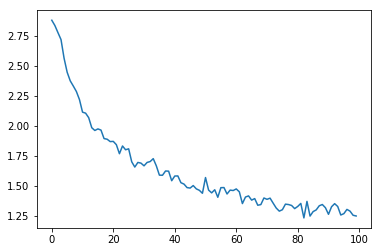

In [79]:
plt.figure()
plt.plot(history)

In [69]:
def evaluate(model, line):
    hidden = model.init_hidden()
    for char in line:
        output, hidden = rnn(char, hidden)
    return output

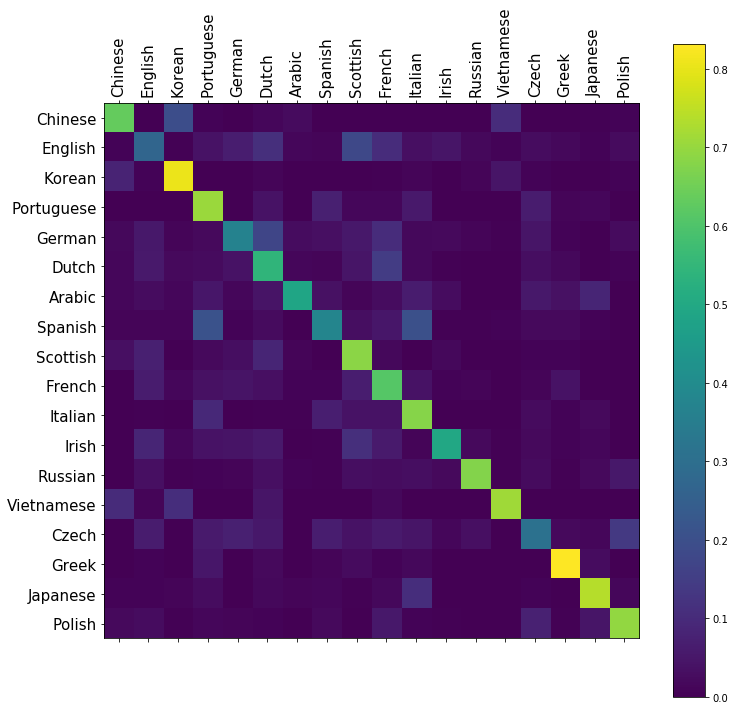

In [75]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    (category, _), (_, t_line) = random_training_example()
    output = evaluate(rnn, t_line)
    guess, guess_i = top_category(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90, fontsize=15)
ax.set_yticklabels([''] + all_categories, fontsize=15)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [83]:
def predict(model, line, top_k=3):
    print('\n> %s' % line)
    with torch.no_grad():
        output = evaluate(model, line_to_tensor(line))
        top_value, top_index = output.topk(top_k, 1, True)
        predictions = []
        for i in range(top_k):
            value = top_value[0][i].item()
            category_index = top_index[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [84]:
predict(rnn, 'Dovesky')
predict(rnn, 'Jackson')
predict(rnn, 'Satoshi')


> Dovesky
(-0.91) Czech
(-1.12) Russian
(-2.05) Polish

> Jackson
(-0.17) Scottish
(-2.41) English
(-3.15) Russian

> Satoshi
(-0.56) Italian
(-1.59) Japanese
(-2.80) Polish


# Generating Names with a Character-Level RNN

https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [85]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, i, h):
        concat = torch.cat((category, i, h), 1)
        hidden = self.i2h(concat)
        output = self.i2o(concat)
        output_concat = torch.cat((hidden, output), 1)
        output = self.o2o(output_concat)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [86]:
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

In [90]:
def category_tensor(category):
    index = all_categories.index(category)
    one_hot = [0] * n_categories
    one_hot[index] = 1
    return torch.LongTensor(one_hot).view(1, n_categories)

In [96]:
def input_tensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for i, letter in enumerate(line):
        index = all_letters.index(letter)
        tensor[i][index] = 1
    return tensor.view(-1, 1, n_letters)

In [104]:
def target_tensor(line):
    letter_indexes = [all_letters.index(letter) for letter in line]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [111]:
def random_training_example():
    category, line = random_training_pair()
    t_category = category_tensor(category)
    t_input = input_tensor(line)
    t_target = target_tensor(line)
    return t_category, t_input, t_target